 # SSDによる物体検出(Keras)

学習済みモデルは以下からダウンロード
https://mega.nz/#F!7RowVLCL!q3cEVRK9jyOSB9el3SssIA

ソースコードは以下を利用
https://github.com/rykov8/ssd_keras/blob/master/SSD.ipynb

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# check auth
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'1_X2HATWkrR6OfZhdMGXoz6KMaBUrCuGG'})
downloaded.GetContentFile('weights_SSD300.hdf5')



In [3]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
import tensorflow as tf

#%matplotlib inline
#plt.rcParams['figure.figsize'] = (8, 8)
#plt.rcParams['image.interpolation'] = 'nearest'



Using TensorFlow backend.


In [0]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [0]:
class BBoxUtility(object):
    def __init__(self, num_classes, priors=None, overlap_threshold=0.5,
                 nms_thresh=0.45, top_k=400):
        self.num_classes = num_classes
        self.priors = priors
        self.num_priors = 0 if priors is None else len(priors)
        self.overlap_threshold = overlap_threshold
        self._nms_thresh = nms_thresh
        self._top_k = top_k
        self.boxes = tf.placeholder(dtype='float32', shape=(None, 4))
        self.scores = tf.placeholder(dtype='float32', shape=(None,))
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)
        self.sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))

    @property
    def nms_thresh(self):
        return self._nms_thresh

    @nms_thresh.setter
    def nms_thresh(self, value):
        self._nms_thresh = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)

    @property
    def top_k(self):
        return self._top_k

    @top_k.setter
    def top_k(self, value):
        self._top_k = value
        self.nms = tf.image.non_max_suppression(self.boxes, self.scores,
                                                self._top_k,
                                                iou_threshold=self._nms_thresh)
        

    def decode_boxes(self, mbox_loc, mbox_priorbox, variances):
        prior_width = mbox_priorbox[:, 2] - mbox_priorbox[:, 0]
        prior_height = mbox_priorbox[:, 3] - mbox_priorbox[:, 1]
        prior_center_x = 0.5 * (mbox_priorbox[:, 2] + mbox_priorbox[:, 0])
        prior_center_y = 0.5 * (mbox_priorbox[:, 3] + mbox_priorbox[:, 1])
        decode_bbox_center_x = mbox_loc[:, 0] * prior_width * variances[:, 0]
        decode_bbox_center_x += prior_center_x
        decode_bbox_center_y = mbox_loc[:, 1] * prior_width * variances[:, 1]
        decode_bbox_center_y += prior_center_y
        decode_bbox_width = np.exp(mbox_loc[:, 2] * variances[:, 2])
        decode_bbox_width *= prior_width
        decode_bbox_height = np.exp(mbox_loc[:, 3] * variances[:, 3])
        decode_bbox_height *= prior_height
        decode_bbox_xmin = decode_bbox_center_x - 0.5 * decode_bbox_width
        decode_bbox_ymin = decode_bbox_center_y - 0.5 * decode_bbox_height
        decode_bbox_xmax = decode_bbox_center_x + 0.5 * decode_bbox_width
        decode_bbox_ymax = decode_bbox_center_y + 0.5 * decode_bbox_height
        decode_bbox = np.concatenate((decode_bbox_xmin[:, None],  decode_bbox_ymin[:, None], decode_bbox_xmax[:, None], decode_bbox_ymax[:, None]), axis=-1)
        decode_bbox = np.minimum(np.maximum(decode_bbox, 0.0), 1.0)
        return decode_bbox

    def detection_out(self, predictions, background_label_id=0, keep_top_k=200,  confidence_threshold=0.01):
        mbox_loc = predictions[:, :, :4]
        variances = predictions[:, :, -4:]
        mbox_priorbox = predictions[:, :, -8:-4]
        mbox_conf = predictions[:, :, 4:-8]
        results = []
        for i in range(len(mbox_loc)):
            results.append([])
            decode_bbox = self.decode_boxes(mbox_loc[i], mbox_priorbox[i], variances[i])
            for c in range(self.num_classes):
                if c == background_label_id:
                    continue
                c_confs = mbox_conf[i, :, c]
                c_confs_m = c_confs > confidence_threshold
                if len(c_confs[c_confs_m]) > 0:
                    boxes_to_process = decode_bbox[c_confs_m]
                    confs_to_process = c_confs[c_confs_m]
                    feed_dict = {self.boxes: boxes_to_process,  self.scores: confs_to_process}
                    idx = self.sess.run(self.nms, feed_dict=feed_dict)
                    good_boxes = boxes_to_process[idx]
                    confs = confs_to_process[idx][:, None]
                    labels = c * np.ones((len(idx), 1))
                    c_pred = np.concatenate((labels, confs, good_boxes),   axis=1)
                    results[-1].extend(c_pred)
            if len(results[-1]) > 0:
                results[-1] = np.array(results[-1])
                argsort = np.argsort(results[-1][:, 1])[::-1]
                results[-1] = results[-1][argsort]
                results[-1] = results[-1][:keep_top_k]
        return results

In [0]:
import keras.backend as K
from keras.engine.topology import InputSpec
from keras.engine.topology import Layer


class Normalize(Layer):
    def __init__(self, scale, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.axis = 3
        else:
            self.axis = 1
        self.scale = scale
        super(Normalize, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)
        init_gamma = self.scale * np.ones(shape)
        self.gamma = K.variable(init_gamma, name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        output *= self.gamma
        return output


class PriorBox(Layer):
    def __init__(self, img_size, min_size, max_size=None, aspect_ratios=None,
                 flip=True, variances=[0.1], clip=True, **kwargs):
        if K.image_dim_ordering() == 'tf':
            self.waxis = 2
            self.haxis = 1
        else:
            self.waxis = 3
            self.haxis = 2
        self.img_size = img_size
        if min_size <= 0:
            raise Exception('min_size must be positive.')
        self.min_size = min_size
        self.max_size = max_size
        self.aspect_ratios = [1.0]
        if max_size:
            if max_size < min_size:
                raise Exception('max_size must be greater than min_size.')
            self.aspect_ratios.append(1.0)
        if aspect_ratios:
            for ar in aspect_ratios:
                if ar in self.aspect_ratios:
                    continue
                self.aspect_ratios.append(ar)
                if flip:
                    self.aspect_ratios.append(1.0 / ar)
        self.variances = np.array(variances)
        self.clip = True
        super(PriorBox, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        num_priors_ = len(self.aspect_ratios)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        num_boxes = num_priors_ * layer_width * layer_height
        return (input_shape[0], num_boxes, 8)

    def call(self, x, mask=None):
        if hasattr(x, '_keras_shape'):
            input_shape = x._keras_shape
        elif hasattr(K, 'int_shape'):
            input_shape = K.int_shape(x)
        layer_width = input_shape[self.waxis]
        layer_height = input_shape[self.haxis]
        img_width = self.img_size[0]
        img_height = self.img_size[1]
        # define prior boxes shapes
        box_widths = []
        box_heights = []
        for ar in self.aspect_ratios:
            if ar == 1 and len(box_widths) == 0:
                box_widths.append(self.min_size)
                box_heights.append(self.min_size)
            elif ar == 1 and len(box_widths) > 0:
                box_widths.append(np.sqrt(self.min_size * self.max_size))
                box_heights.append(np.sqrt(self.min_size * self.max_size))
            elif ar != 1:
                box_widths.append(self.min_size * np.sqrt(ar))
                box_heights.append(self.min_size / np.sqrt(ar))
        box_widths = 0.5 * np.array(box_widths)
        box_heights = 0.5 * np.array(box_heights)
        # define centers of prior boxes
        step_x = img_width / layer_width
        step_y = img_height / layer_height
        linx = np.linspace(0.5 * step_x, img_width - 0.5 * step_x,
                           layer_width)
        liny = np.linspace(0.5 * step_y, img_height - 0.5 * step_y,
                           layer_height)
        centers_x, centers_y = np.meshgrid(linx, liny)
        centers_x = centers_x.reshape(-1, 1)
        centers_y = centers_y.reshape(-1, 1)
        # define xmin, ymin, xmax, ymax of prior boxes
        num_priors_ = len(self.aspect_ratios)
        prior_boxes = np.concatenate((centers_x, centers_y), axis=1)
        prior_boxes = np.tile(prior_boxes, (1, 2 * num_priors_))
        prior_boxes[:, ::4] -= box_widths
        prior_boxes[:, 1::4] -= box_heights
        prior_boxes[:, 2::4] += box_widths
        prior_boxes[:, 3::4] += box_heights
        prior_boxes[:, ::2] /= img_width
        prior_boxes[:, 1::2] /= img_height
        prior_boxes = prior_boxes.reshape(-1, 4)
        if self.clip:
            prior_boxes = np.minimum(np.maximum(prior_boxes, 0.0), 1.0)
        # define variances
        num_boxes = len(prior_boxes)
        if len(self.variances) == 1:
            variances = np.ones((num_boxes, 4)) * self.variances[0]
        elif len(self.variances) == 4:
            variances = np.tile(self.variances, (num_boxes, 1))
        else:
            raise Exception('Must provide one or four variances.')
        prior_boxes = np.concatenate((prior_boxes, variances), axis=1)
        prior_boxes_tensor = K.expand_dims(K.variable(prior_boxes), 0)
        if K.backend() == 'tensorflow':
            pattern = [tf.shape(x)[0], 1, 1]
            prior_boxes_tensor = tf.tile(prior_boxes_tensor, pattern)
        elif K.backend() == 'theano':
            #TODO
            pass
        return prior_boxes_tensor

In [0]:
import keras.backend as K
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.layers.merge import concatenate
from keras.models import Model

def SSD300(input_shape, num_classes=21):
    net = {}
    # Block 1
    input_tensor = input_tensor = Input(shape=input_shape)
    img_size = (input_shape[1], input_shape[0])
    net['input'] = input_tensor
    net['conv1_1'] = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(net['input'])
    net['conv1_2'] = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(net['conv1_1'])
    net['pool1'] = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool1')(net['conv1_2'])
    # Block 2
    net['conv2_1'] = Conv2D(128, (3, 3), activation='relu',  padding='same', name='conv2_1')(net['pool1'])
    net['conv2_2'] = Conv2D(128, (3, 3), activation='relu',  padding='same', name='conv2_2')(net['conv2_1'])
    net['pool2'] = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool2')(net['conv2_2'])
    # Block 3
    net['conv3_1'] = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(net['pool2'])
    net['conv3_2'] = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(net['conv3_1'])
    net['conv3_3'] = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(net['conv3_2'])
    net['pool3'] = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool3')(net['conv3_3'])
    # Block 4
    net['conv4_1'] = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(net['pool3'])
    net['conv4_2'] = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(net['conv4_1'])
    net['conv4_3'] = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(net['conv4_2'])
    net['pool4'] = MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='pool4')(net['conv4_3'])
    # Block 5
    net['conv5_1'] = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(net['pool4'])
    net['conv5_2'] = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(net['conv5_1'])
    net['conv5_3'] = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(net['conv5_2'])
    net['pool5'] = MaxPooling2D((3, 3), strides=(1, 1), padding='same', name='pool5')(net['conv5_3'])
    # FC6
    net['fc6'] = Conv2D(1024, (3, 3), dilation_rate=(6, 6), activation='relu', padding='same', name='fc6')(net['pool5'])
    # x = Dropout(0.5, name='drop6')(x)
    # FC7
    net['fc7'] = Conv2D(1024, (1, 1), activation='relu', padding='same', name='fc7')(net['fc6'])
    # x = Dropout(0.5, name='drop7')(x)
    # Block 6
    net['conv6_1'] = Conv2D(256, (1, 1), activation='relu', padding='same', name='conv6_1')(net['fc7'])
    net['conv6_2'] = Conv2D(512, (3, 3), strides=(2, 2), activation='relu', padding='same', name='conv6_2')(net['conv6_1'])
    # Block 7
    net['conv7_1'] = Conv2D(128, (1, 1), activation='relu', padding='same',  name='conv7_1')(net['conv6_2'])
    net['conv7_2'] = ZeroPadding2D()(net['conv7_1'])
    net['conv7_2'] = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='valid', name='conv7_2')(net['conv7_2'])
    # Block 8
    net['conv8_1'] = Conv2D(128, (1, 1), activation='relu', padding='same', name='conv8_1')(net['conv7_2'])
    net['conv8_2'] = Conv2D(256, (3, 3), strides=(2, 2), activation='relu', padding='same', name='conv8_2')(net['conv8_1'])
    # Last Pool
    net['pool6'] = GlobalAveragePooling2D(name='pool6')(net['conv8_2'])
    # Prediction from conv4_3
    net['conv4_3_norm'] = Normalize(20, name='conv4_3_norm')(net['conv4_3'])
    num_priors = 3
    x = Conv2D(num_priors * 4, (3, 3), padding='same', name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_loc'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_loc_flat')
    net['conv4_3_norm_mbox_loc_flat'] = flatten(net['conv4_3_norm_mbox_loc'])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_conf'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_conf_flat')
    net['conv4_3_norm_mbox_conf_flat'] = flatten(net['conv4_3_norm_mbox_conf'])
    priorbox = PriorBox(img_size, 30.0, aspect_ratios=[2], variances=[0.1, 0.1, 0.2, 0.2], name='conv4_3_norm_mbox_priorbox')
    net['conv4_3_norm_mbox_priorbox'] = priorbox(net['conv4_3_norm'])
    # Prediction from fc7
    num_priors = 6
    net['fc7_mbox_loc'] = Conv2D(num_priors * 4, (3, 3),  padding='same', name='fc7_mbox_loc')(net['fc7'])
    flatten = Flatten(name='fc7_mbox_loc_flat')
    net['fc7_mbox_loc_flat'] = flatten(net['fc7_mbox_loc'])
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    net['fc7_mbox_conf'] = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(net['fc7'])
    flatten = Flatten(name='fc7_mbox_conf_flat')
    net['fc7_mbox_conf_flat'] = flatten(net['fc7_mbox_conf'])
    priorbox = PriorBox(img_size, 60.0, max_size=114.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='fc7_mbox_priorbox')
    net['fc7_mbox_priorbox'] = priorbox(net['fc7'])
    # Prediction from conv6_2
    num_priors = 6
    x = Conv2D(num_priors * 4, (3, 3), padding='same',  name='conv6_2_mbox_loc')(net['conv6_2'])
    net['conv6_2_mbox_loc'] = x
    flatten = Flatten(name='conv6_2_mbox_loc_flat')
    net['conv6_2_mbox_loc_flat'] = flatten(net['conv6_2_mbox_loc'])
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(net['conv6_2'])
    net['conv6_2_mbox_conf'] = x
    flatten = Flatten(name='conv6_2_mbox_conf_flat')
    net['conv6_2_mbox_conf_flat'] = flatten(net['conv6_2_mbox_conf'])
    priorbox = PriorBox(img_size, 114.0, max_size=168.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv6_2_mbox_priorbox')
    net['conv6_2_mbox_priorbox'] = priorbox(net['conv6_2'])
    # Prediction from conv7_2
    num_priors = 6
    x = Conv2D(num_priors * 4, (3, 3), padding='same',
                      name='conv7_2_mbox_loc')(net['conv7_2'])
    net['conv7_2_mbox_loc'] = x
    flatten = Flatten(name='conv7_2_mbox_loc_flat')
    net['conv7_2_mbox_loc_flat'] = flatten(net['conv7_2_mbox_loc'])
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(net['conv7_2'])
    net['conv7_2_mbox_conf'] = x
    flatten = Flatten(name='conv7_2_mbox_conf_flat')
    net['conv7_2_mbox_conf_flat'] = flatten(net['conv7_2_mbox_conf'])
    priorbox = PriorBox(img_size, 168.0, max_size=222.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='conv7_2_mbox_priorbox')
    net['conv7_2_mbox_priorbox'] = priorbox(net['conv7_2'])
    # Prediction from conv8_2
    num_priors = 6
    x = Conv2D(num_priors * 4, (3, 3), padding='same', name='conv8_2_mbox_loc')(net['conv8_2'])
    net['conv8_2_mbox_loc'] = x
    flatten = Flatten(name='conv8_2_mbox_loc_flat')
    net['conv8_2_mbox_loc_flat'] = flatten(net['conv8_2_mbox_loc'])
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Conv2D(num_priors * num_classes, (3, 3), padding='same', name=name)(net['conv8_2'])
    net['conv8_2_mbox_conf'] = x
    flatten = Flatten(name='conv8_2_mbox_conf_flat')
    net['conv8_2_mbox_conf_flat'] = flatten(net['conv8_2_mbox_conf'])
    priorbox = PriorBox(img_size, 222.0, max_size=276.0, aspect_ratios=[2, 3],  variances=[0.1, 0.1, 0.2, 0.2], name='conv8_2_mbox_priorbox')
    net['conv8_2_mbox_priorbox'] = priorbox(net['conv8_2'])
    # Prediction from pool6
    num_priors = 6
    x = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(net['pool6'])
    net['pool6_mbox_loc_flat'] = x
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Dense(num_priors * num_classes, name=name)(net['pool6'])
    net['pool6_mbox_conf_flat'] = x
    priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3], variances=[0.1, 0.1, 0.2, 0.2], name='pool6_mbox_priorbox')
    if K.image_dim_ordering() == 'tf':
        target_shape = (1, 1, 256)
    else:
        target_shape = (256, 1, 1)
    net['pool6_reshaped'] = Reshape(target_shape, name='pool6_reshaped')(net['pool6'])
    net['pool6_mbox_priorbox'] = priorbox(net['pool6_reshaped'])
    # Gather all predictions
    net['mbox_loc'] = concatenate([net['conv4_3_norm_mbox_loc_flat'], net['fc7_mbox_loc_flat'], net['conv6_2_mbox_loc_flat'],
                             net['conv7_2_mbox_loc_flat'],  net['conv8_2_mbox_loc_flat'],  net['pool6_mbox_loc_flat']], axis=1, name='mbox_loc')
    net['mbox_conf'] = concatenate([net['conv4_3_norm_mbox_conf_flat'],  net['fc7_mbox_conf_flat'], net['conv6_2_mbox_conf_flat'],
                             net['conv7_2_mbox_conf_flat'],  net['conv8_2_mbox_conf_flat'],  net['pool6_mbox_conf_flat']], axis=1, name='mbox_conf')
    net['mbox_priorbox'] = concatenate([net['conv4_3_norm_mbox_priorbox'], net['fc7_mbox_priorbox'], net['conv6_2_mbox_priorbox'],
                             net['conv7_2_mbox_priorbox'], net['conv8_2_mbox_priorbox'],  net['pool6_mbox_priorbox']], axis=1,  name='mbox_priorbox')
    
    if hasattr(net['mbox_loc'], '_keras_shape'):
        num_boxes = net['mbox_loc']._keras_shape[-1] // 4
    elif hasattr(net['mbox_loc'], 'int_shape'):
        num_boxes = K.int_shape(net['mbox_loc'])[-1] // 4
    net['mbox_loc'] = Reshape((num_boxes, 4),  name='mbox_loc_final')(net['mbox_loc'])
    net['mbox_conf'] = Reshape((num_boxes, num_classes), name='mbox_conf_logits')(net['mbox_conf'])
    net['mbox_conf'] = Activation('softmax',  name='mbox_conf_final')(net['mbox_conf'])
    net['predictions'] = concatenate([net['mbox_loc'],  net['mbox_conf'], net['mbox_priorbox']],   axis=2,  name='predictions')
    model = Model(net['input'], net['predictions'])

    return model

In [0]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [32]:
from google.colab import files
uploaded = files.upload()

Saving IITG_2018_01.jpg to IITG_2018_01 (1).jpg


In [10]:
!ls

adc.json  IITG_2018_01.jpg  sample_data  weights_SSD300.hdf5


In [0]:
inputs = []
images = []
img_path = './IITG_2018_01.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [35]:
%%time
preds  =  model.predict(inputs, batch_size=1, verbose=1)


1/1 [==============================] - 0s 85ms/step
CPU times: user 23.8 ms, sys: 10.2 ms, total: 34.1 ms
Wall time: 86.9 ms


In [0]:
results = bbox_util.detection_out(preds)

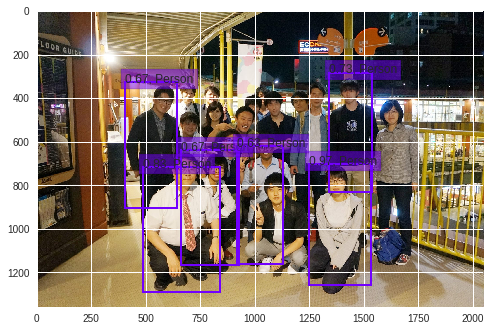

In [37]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()